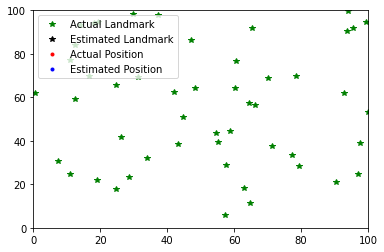

No handles with labels found to put in legend.


IndexError: list index out of range

In [1]:
from random import uniform
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

WORLD_SIZE = 100.0
MEASUREMENT_RANGE = 100.0
MOTION_NOISE = 1.0
MEASUREMENT_NOISE = 2.0
N_LANDMARKS = 50
LANDMARKS = np.array(
    [[uniform(0, WORLD_SIZE), uniform(0, WORLD_SIZE)]
     for _ in range(N_LANDMARKS)]
    )

omega = np.array([[[0.0, 0.0] for _ in range(N_LANDMARKS + 1)]
                              for _ in range(N_LANDMARKS + 1)])
xi = np.array([[0.0, 0.0] for _ in range(N_LANDMARKS + 1)])
omega[0, 0, :] = np.array([1.0, 1.0])
xi[0, :] = np.array([WORLD_SIZE/4, WORLD_SIZE/4])

def slam(i, dx, dy, Z):
    global omega, xi
    omega = np.insert(omega, i + 1, 0, axis=0)
    omega = np.insert(omega, i + 1, 0, axis=1)
    xi = np.insert(xi, i + 1, 0, axis=0)
    for meas in Z:
        j, x, y = meas
        omega[i, i] = omega[i, i] + 1/MEASUREMENT_NOISE
        omega[i, i + j + 2] = omega[i, i + j + 2] - 1/MEASUREMENT_NOISE
        omega[i + j + 2, i] = omega[i + j + 2, i] - 1/MEASUREMENT_NOISE
        omega[i + j + 2, i + j + 2] = omega[i + j + 2, i + j + 2] + 1/MEASUREMENT_NOISE
        xi[i, :] = xi[i, :] - np.array([x, y])/MEASUREMENT_NOISE
        xi[i + j + 2, :] = xi[i + j + 2, :] + np.array([x, y])/MEASUREMENT_NOISE
    omega[i, i] = omega[i, i] + 1/MOTION_NOISE
    omega[i + 1, i + 1] = omega[i + 1, i + 1] + 1/MOTION_NOISE
    omega[i + 1, i] = omega[i + 1, i] - 1/MOTION_NOISE
    omega[i, i + 1] = omega[i, i + 1] - 1/MOTION_NOISE
    xi[i, :] = xi[i, :] - np.array([dx, dy])/MOTION_NOISE
    xi[i + 1, :] = xi[i + 1, :] + np.array([dx, dy])/MOTION_NOISE
    mu_x = np.linalg.inv(omega[:, :, 0]).dot(xi[:, 0])
    mu_y = np.linalg.inv(omega[:, :, 1]).dot(xi[:, 1])
    return np.c_[mu_x, mu_y]

class Robot:
    def __init__(self,
                 world_size=WORLD_SIZE,
                 measurement_range=MEASUREMENT_RANGE,
                 motion_noise=MOTION_NOISE,
                 measurement_noise=MEASUREMENT_NOISE):
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.x = world_size/4
        self.y = world_size/4

    def move(self, dx, dy):
        x = self.x + dx + uniform(-1, 1)*self.motion_noise
        y = self.y + dy + uniform(-1, 1)*self.motion_noise
        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True

    def sense(self):
        Z = []
        for i, landmark in enumerate(LANDMARKS):
            dx = landmark[0] - self.x + uniform(-1, 1)*self.measurement_noise
            dy = landmark[1] - self.y + uniform(-1, 1)*self.measurement_noise
            if self.measurement_range < 0.0 or sqrt(dx**2 + dy**2) <= self.measurement_range:
                Z.append([i, dx, dy])
        return Z

    def __repr__(self):
        return 'Robot: [x=%.5f y=%.5f]' % (self.x, self.y)

fig, ax = plt.subplots()
robot = Robot()
ax.plot(LANDMARKS[:, 0], LANDMARKS[:, 1], 'g*', label='Actual Landmark')
estimated_landmarks, = ax.plot([], [], 'k*', label='Estimated Landmark')
actual_position, = ax.plot([], [], 'r.', label='Actual Position')
estimated_position, = ax.plot([], [], 'b.', label='Estimated Position')
actual_path, = ax.plot([], [], 'r--')
estimated_path, = ax.plot([], [], 'b:')
actual_values = []
estimated_values = []

def init():
    ax.set_xlim(0, WORLD_SIZE)
    ax.set_ylim(0, WORLD_SIZE)
    plt.legend(loc='upper left')
    return (actual_position, estimated_position, estimated_landmarks,
            actual_path, estimated_path,)

dx = [1 for _ in range(50)] + [0 for _ in range(50)]
dx += [-1 for _ in range(50)] + [0 for _ in range(50)]
dy = [0 for _ in range(50)] + [1 for _ in range(50)]
dy += [0 for _ in range(50)] + [-1 for _ in range(50)]
def animate(i):
    Z = robot.sense()
    mu = slam(i, dx[i], dy[i], Z)
    robot.move(dx[i], dy[i])
    actual_values.append([robot.x, robot.y])
    estimated_values.append([mu[i + 1, 0], mu[i + 1, 1]])
    actual_path.set_data([pos[0] for pos in actual_values], [pos[1] for pos in actual_values])
    estimated_path.set_data([pos[0] for pos in estimated_values], [pos[1] for pos in estimated_values])
    actual_position.set_data(robot.x, robot.y)
    estimated_position.set_data(mu[i + 1, 0], mu[i + 1, 1])
    est_lm = np.array([[mu[i + j + 2, 0], mu[i + j + 2, 1]] for j in range(N_LANDMARKS)])
    estimated_landmarks.set_data(est_lm[:, 0], est_lm[:, 1])
    return (actual_position, estimated_position, estimated_landmarks,
            actual_path, estimated_path,)


anim = animation.FuncAnimation(fig, animate, 200, interval=50, init_func=init)
plt.show()
writergif = animation.PillowWriter(fps=30) 
anim.save('slam.gif', writer=writergif)